In [1]:
import tensorflow as tf
from tensorflow.contrib import autograph #import autograph from contrib package to use graph mode
%load_ext tensorboard
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd 
import seaborn as sns
from scipy import stats 
from scipy import linalg

In [2]:
print(tf.__version__)

1.15.0


-----

**Hw#2 Solution**

In [3]:
## Single input node: #with this shape a[3,5]
a = np.mat([[2,4,5,6,7], [4,2,6,7,9], [9,8,3,3,1]]) # numpy matrix
a = tf.constant(a, dtype = np.int64, name="input_matrix")

#Operations
b = tf.reduce_prod(a, name = "prod_b")
c = tf.reduce_mean(a, name ="mean")
e = tf.add(b,c, name="add_d")
d = tf.reduce_sum(a, name ="sum_a")
f = tf.add(e,d, name="final_add")

# run the session
sess = tf.Session()
sess.run(f)

# To create the graph:
sess.graph.as_graph_def()
file_writer = tf.summary.FileWriter('./graphs', sess.graph)

# We clean up before we exit()
file_writer.close()
sess.close()


In [4]:
tensorboard --logdir="./graphs" 

Reusing TensorBoard on port 6006 (pid 3916), started 2:03:32 ago. (Use '!kill 3916' to kill it.)

----
**Generic frame of modeling in Machine Learning**

Goals: 
- Focus on supervised learning problems, where we train an inference model with an input dataset, along with the real or expected output for each example
- "inference model": is a series of mathematical operations that we apply to our data

**Training Loop:**

- Initializes the model parameters for the first time
- Reads the traing data along with the expected output data for each data example
- Executes the inference model on the training data, so it calculates for each training input example
- Computes the loss
- Adjusts the model parameters
- loop repeats through several cycles

**After training, we apply an evaluation phase**
- we execute the inference against a different set data to which we also have the expected output and evaluate the loss for it.
- Given how this dataset contains examples unknown for the model, the evaluation tells us how well the model predicts beyond its training.
-  A very common practice is to take the original dataset and randomly split it in 70% of the examples for training, and 30% for evaluation

---
**Generic Frame for the model code**

```python 
# initialize variables/model parameters

#define the training loop operations 

def inference(X):
    pass
    # compute inference model over data X and return the result 

def loss(X,Y):
    pass
    #Compute loss over training data X and expected outputs Y

def inputs():
    pass
    # read/generate input training data X and expected data Y 
    
def train(total_loss):
    pass
    # train/adjust model parameters according to computed total loss

def evaluate(sess, X,Y):
    pass
    #evaluate the resulting trained model
    
    
# Launch the graph in a session, setup boilerplate

with tf.Session() as sess:
    tf.initialize_all_variables().run()
    
    X,Y = inputs()
    
    total_loss = loss(X,Y)
    train_op = train(total_loss)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess = sess, coord =coord)
    
    #actual training loop
    training_steps = 1000
    for step in range(training_steps):
        sess.run([train_op])
        if step % 10 == 0:
            print("loss: ", sess.run([total_loss]))
    evaluate(sess, X, y)
    
    coord.request_stop()
    coord.join(threads)
    sess.close()
 
 ```

-----

**Saving Checkpoints in TF**
 - Queing and threading in tensorflow

```python

# Queuing and Threading:
dummy_input = tf.random_normal([8], mean =0.5, stddev=2)
dummy_input = tf.Print(dummy_input, data=[dummy_input], message="new dummy inputs have been created: ", summarize = 6)

q = tf.FIFOQueue(capacity=3, dtypes=tf.float32)
enqueue_op = q.enqueue_many(dummy_input)

#Now set up a queue runner to handle enqueue_op outside of the main thread asynchronously
qr = tf.train.QueueRunner(q, [enqueue_op] * 10)
tf.train.add_queue_runner(qr)

data = q.dequeue()
data = tf.Print(data, data=[q.size(), data], message= "this is how many items are left in q: ")
#create a fake graph that we can call upon
fg =data +1

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord= coord)
    #Now dequeue a few times, and we should see the number of items in the queue decrease
    sess.run(fg)
    sess.run(fg)
    sess.run(fg)
    # we have a queue runner on another thread making sure the queue is fill asynchronously 
    sess.run(fg)
    sess.run(fg)
    sess.run(fg)
    # this will print, but not necessarily after the 6th call of sess.run(fg)
    print("We're here!")
    coord.request_stop()
    coord.join(threads)
    
```

----

**Saving Training checkpoints**


- As we already stated, training models implies updating their parameters, or variables in Tensorflow, through many training cycles
- Variables are stored in memory, so if the computer would lose power after many hours of training, we would lose all that work, so …
- We use tf.train.Saver class to save the graph variables in proprietary binary files
- We should periodically save the variables, create a checkpoint file, and eventually restore the training from the most recent checkpoint if needed.

```python

#model definition code ...

# Create a saver
saver = tf.train.Saver()

#Launch the graph in a session, setup boilerplate
with tf.Session() sess:
    # model set up ...
    
    initial_step = 0
    # verify if we don't have a checkpoint saved already
    cpkt = tf.train.get_checkpoint_state(os.path.dirname(__file__))
        if cpkt and ckpt.model_checkpoint_path:
            # restores from checkpint 
            saver.restore(sess, cpkt.model_checkpoint_path)
            initial_step = int(cpkt.model_checkpoint_path.rsplit('-',1)[1]

    #actual training loop
    training_steps = 1000
    for step in range(training_steps):
        sess.run([train_op])
        
        if step % 1000 == 0:
            saver.save(sess, 'my-model', global_step = step)
            
    #evaluation...
    
    saver.save(sess, "my-model", global_step = training_steps)
    sess.close()

```

**Linear Regression**

```python

Y= XW.T + b
```

**Weights**
- However, instead of transposing weights, we can simply define them as a single column vector


In [5]:
# Initialize variables/model parameters

W = tf.Variable(tf.zeros([2,1]), name = "weights")
b = tf.Variable(0., name="bias")

def inference(X):
    return tf.matmul(X,W) + b

**Compute the loss**

- For a simple model we can use the **squared error**:
    - It sums the squared difference of all the predicted values for each training example with their corresponding expected values.
    - Algebraically it is the squared Euclidean distance between the **predicted output vector and the expected one**
- Graphically in a 2d dataset the error is the length of the vertical line that you can trace from the expected data point to the predicted regression line.
- It is also known as **L2 norm or L2 loss function.**
- We use it squared to avoid computing the square root, since it makes no difference for trying to minimize the loss and saves a computing step:

In [6]:
def loss(X,Y):
    Y_predicted = inference(X)
    return tf.reduce_sum(tf.squared_difference(Y,Y_predicted))

**Model Training operation** 
- We will use the gradient descent algorithm for optimizing the model parameters:
- when you run it, you will see printed how the loss gets smaller on each training step

In [7]:
def train(total_loss):
    learning_rate = 0.0000001
    return tf.train.GradientDescentOptimizer(learning_rate).minimize(total_loss)

**Evaluation**
- Now that we trained the model, its time to evaluate it
- Also, the output values are in-between the boundaries of the original trained values.

In [8]:
def evaluate(sess, X, Y):
    print(sess.run(inference([[80., 25.]]))) # ~303
    print(sess.run(inference([[65., 25.]]))) # ~ 256

**Launch Graph in Session**

```python
with tf.Session() as sess:
    tf.initialize_all_variables().run()

    X,Y = inputs()
    total_loss = loss(X,Y)
    train_op = train(total_loss)

    #actual training loop
    training_steps = 10000
    for step in range(training_steps):
        sess.run([train_op])
        if step % 1000 == 0:
            print("Epoch: ", step, "loss: ", sess.run([total_loss]))
    
    print("Final model W= ", sess.run(W) "b=" , sess.run(b))
    evaluate(sess, X, Y)

    sess.close()
    
```

**Linear Regression in TF 1.x**

```python 

basic_graph = tf.Graph()
with basic_graph.as_default():
    a = tf.placeholder(name="a",
                      dtype= tf.float32,
                      shape =(None, 5))
    W = tf.Variable(tf.random_normal((5,3)), name = "W") #initialize it with random
    b = tf.Variable(tf.random_normal((3,)), name="b") # initialize it with random
    
#Create a session to run the graph
with tf.Session(graph=basic_graph) as sess:
    #writer =tf.summary.FileWriter('./graphs/basic_addition_graph', sess.graph)
    #tensorboard --logdir="./graphs/basic_addition_graph -port=8800"
    print(sess.run(y, feed_dict={a: np.random.uniform(size = (500,5))}))
    print(b.eval)
    
```


---

**Logistic Regression**

- sigmoid function
        
        f(x) = 1/(1+e)**-x
        
 
 - In order to feed the function with the multiple dimensions, or features from the examples of our training datasets, we need to combine them into a single value
 
```python

# same parameters and variable initializations as log reg
W = tf.Variable(tf.zeros([5,1]), name ="weights")
b = tf.Variable(0., name="bias")

# former inference is now sued for combinding inputs
def combine_inputs(X):
    return tf.matmul(X,W) + b

#new inferred value is the sigmoid applied to the former
def inference(X):
    return tf.sigmoid(combine_inputs(X))

```

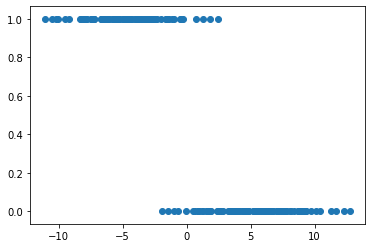

In [9]:
learning_rate = 0.01 
training_epochs = 500

#Defining the sigmoid function:
def sigmoid(x):
    return 1./ (1. + np.exp(-x))

# Create our data points on the x and y axis:
x1 = np.random.normal(5,3,100)
x2 = np.random.normal(-5, 3, 100)
xs = np.append(x1, x2)
ys = np.asarray([0.] * len(x1) + [1.] * len(x2))
plt.scatter(xs,ys)

In [10]:
# Create our parameters and palceholders for X and Y to feed them with the data above:
X = tf.placeholder(tf.float32, shape=(None,), name="x")
Y =X = tf.placeholder(tf.float32, shape=(None,), name="y")
w = tf.Variable([0.,0.], name="parameter", trainable = True)
y_model = tf.sigmoid(-(w[1] * X + w[0]))

In [11]:
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    print(sess.run(y_model, feed_dict={X:xs}))

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5]


---

**not finished**